<a href="https://colab.research.google.com/github/HoTrungQuan2004/Introduction-to-Data-Science-and-AI/blob/main/Assignment_HME_recognition_ColabVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Student information:
### Name: Hồ Trung Quân
### ID: 10422069
### Gmail: 10422069@student.vgu.edu.vn


I will use this model checkpoint on wandb.ai to be graded: cuong-nt-vgu-ai-2025/math_online_2025/model-pixkwijx:v4




In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ntcuong2103_crohme2019_path = kagglehub.dataset_download('ntcuong2103/crohme2019')

print('Data source import complete.')


Data source import complete.


In [ ]:
# If it is failed, run the above cell again to fix
assert ntcuong2103_crohme2019_path == "/kaggle/input/crohme2019"


## **CROHME Temporal Sequence Classification (CROHME-CTC) Baseline**

In this project, we will build and train a recurrent neural network (RNN) for translating handwritten mathematical expressions into sequence of symbols and relations based on Symbol Relation Tree and CROHME dataset.

The model we'll be using is a simple RNN with a single layer of Bidirectional LSTM cells. We will use Connectionist Temporal Classification (CTC) loss to train the model.

The model is trained on the CROHME dataset, which contains handwritten mathematical expressions in the form of Symbol Relation Trees. The dataset is preprocessed and converted into a sequence of symbols and relations, which is used as the input to the model.

Your job is to feature engineer the input data and train the model to achieve the best performance possible. Additionally, consider implementing data augmentation techniques to enhance the training dataset.

Some features from the project:

*   Public competition dataset: CROHME https://paperswithcode.com/dataset/crohme-2019
*   Advance data preparation: time series feature extraction, collate function
*   High level API of pytorch lightning
*   Experiment tracking with Weight and Biases



## Dependencies

In [ ]:
!pip install pytorch-lightning torchmetrics wandb --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 33.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchmetrics.text import EditDistance

import numpy as np
import pandas as pd
import os

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
import wandb

import xml.etree.ElementTree as ET
from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt
from helper import *
from collections.abc import Sequence
from typing import Literal, Optional, Union

import json

In [ ]:
# mount crohme2019 -> dataset
!ln -s /kaggle/input/crohme2019 dataset

In [ ]:
# Bonus 1
RELATIONS = {"Right", "Above", "Below", "Sup", "Sub", "Inside", "NoRel"}

def is_relation(token):
    return token in RELATIONS

def extract_symbols(tokens):
    return [t for t in tokens if not is_relation(t)]

def extract_relations(tokens):
    return [t for t in tokens if is_relation(t)]

> The above command created a symbolic link
> dataset -> /kaggle/input/crohme2019
>
> We can now access the dataset from current directory instead of /kaggle/input

In [ ]:
# This code for displaying current directory tree, you don't need to run.

!sudo apt-get install tree
!tree -L 3 dataset

In [ ]:
paths = [
    "dataset/crohme2019_train.txt",
    "dataset/crohme2019_test.txt",
    "dataset/crohme2019_valid.txt",
]

## Task 1: Build Vocabulary

Builds and manages a vocabulary for converting characters (tokens) to indices (encoding) and vice-versa (decoding). This is essential for processing text data in machine learning tasks, particularly for sequence-to-sequence models like those used in handwriting recognition or mathematical expression translation.

In this project, the vocabulary is for encoding the target sequence (for example: "- Right \\sqrt Inside 2") into a sequence of indices ([5, 37, 74, 30, 10]). It is constructed from multiple annotation files (train, test, and validation sets) and includes a special blank character (this is for CTC loss). It supports encoding (tokens to indices) and decoding (indices to tokens) operations.


> _You will need to build the `class Vocab` using the two functions provided. Also the vocabulary should be exported as a JSON file so that we can reuse it later in the dataset._

***Input***: the path to the dataset files _(train, valid, and test)_.


```python
paths = [
    "dataset/crohme2019_train.txt",
    "dataset/crohme2019_test.txt",
    "dataset/crohme2019_valid.txt",
]
```

***Output***: the vocabulary.

```python
vocab = {
    "a": 0,
    "b": 1,
    "c": 2,
    ...
}
```

In [ ]:
df = pd.read_csv(paths[1], sep="\t", header=None, names=["path", "label"]).dropna().astype(str)

In [ ]:
df.head()

,path,label
0,crohme2019/test/UN19_1032_em_455.inkml,4 Right n Right - Right 4 Right ) NoRel ( NoRe...
1,crohme2019/test/UN19_1044_em_632.inkml,\phi Sub 0 NoRel = Right d Right x Sup 1 Right...
2,crohme2019/test/UN19wb_1111_em_1039.inkml,9 Right \times Right 9 Right + Right 1 Right 3...
3,crohme2019/test/UN19_1028_em_394.inkml,\tan Right \alpha Right \tan Right \theta Sup ...
4,crohme2019/test/UN19_1005_em_64.inkml,a Right = NoRel 1 NoRel - Below \sqrt Inside 2...


In [ ]:
def get_unique_chars(paths) -> set:
    res = set()
    for i in df['label'].apply(lambda x: x.strip().split()):
        res.update(i)
    return res

len(get_unique_chars(paths[0]))

108

In [ ]:
unique_chars = get_unique_chars(paths[0])
unique_chars

{'!',
 '(',
 ')',
 '+',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '=',
 'A',
 'Above',
 'B',
 'Below',
 'C',
 'COMMA',
 'E',
 'F',
 'G',
 'H',
 'I',
 'Inside',
 'L',
 'M',
 'N',
 'NoRel',
 'P',
 'R',
 'Right',
 'S',
 'Sub',
 'Sup',
 'T',
 'V',
 'X',
 'Y',
 '[',
 '\\Delta',
 '\\alpha',
 '\\beta',
 '\\cos',
 '\\div',
 '\\exists',
 '\\forall',
 '\\gamma',
 '\\geq',
 '\\gt',
 '\\in',
 '\\infty',
 '\\int',
 '\\lambda',
 '\\ldots',
 '\\leq',
 '\\lim',
 '\\log',
 '\\lt',
 '\\mu',
 '\\neq',
 '\\phi',
 '\\pi',
 '\\pm',
 '\\prime',
 '\\rightarrow',
 '\\sigma',
 '\\sin',
 '\\sqrt',
 '\\sum',
 '\\tan',
 '\\theta',
 '\\times',
 '\\{',
 '\\}',
 ']',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '|'}

The vocabulary should be sorted by ascii table. The first character (index 0) must be blank (`''`).

In [ ]:
def chr2idx(unique_chars: set) -> dict:
    unique_chars.add('')
    return {char: idx for idx, char in enumerate(sorted(unique_chars))}

vocab = chr2idx(get_unique_chars(paths[0]))

assert vocab[""] == 0
assert vocab["|"] == 108
assert vocab["\\pi"] == 68
assert vocab["\\exists"] == 51
assert len(vocab) == 109

In [ ]:
class Vocab:
    """

    Attributes:
        paths (list): A list of file paths to the annotation files.
        char2idx (dict): A dictionary mapping characters to their corresponding indices.  This is the primary vocabulary.
        idx2char (dict): A reverse mapping from indices to characters, facilitating decoding.

    Methods:
        build_vocab(): Builds the vocabulary from the specified annotation files, sorting characters lexicographically and adding a blank character.
        get_vocab(): Returns the character-to-index vocabulary.
        save_vocab(path): Saves the vocabulary to a JSON file.
        encode(tokens): Converts a list of tokens (characters) into a list of their corresponding indices.
        decode(ids): Converts a list of indices back into a list of tokens (characters).
    """
    def __init__(self, vocab_file=None):
        self.char2idx = {}
        if vocab_file is not None:
            self.char2idx = json.load(open(vocab_file))
        self.idx2char = {v: k for k, v in self.char2idx.items()}

    def build_vocab(self, annotations) -> None:
        # TODO: build vocab from all annotation files

        #vocab = {}

        # assign vocab to the class
        #self.char2idx = vocab

        vocab_set = set()

        for file_path in annotations:
            with open(file_path, 'r', encoding="utf-8") as f:
                for line in f:
                    parts = line.strip().split("\t")
                    if len(parts) == 2:
                      _, target = parts
                      tokens = target.strip().split()
                      vocab_set.update(tokens)

        vocab_list = sorted(list(vocab_set))
        vocab_list.insert(0, "<blank>")

        self.char2idx = {char: idx for idx, char in enumerate(vocab_list)}
        self.idx2char = {idx: char for char, idx in self.char2idx.items()}

    def get_vocab(self) -> dict:  # getter
        return self.char2idx

    def save_vocab(self, path: str) -> None:  # save vocab to json file
        with open(path, 'w') as f:
            json.dump(self.char2idx, f)

    def encode(self, tokens):
        return [self.char2idx[token] for token in tokens]

    def decode(self, ids):
        return [self.idx2char[id] for id in ids]


In [ ]:
# CHECKPOINT: build vocab from annotations
annotations = [
    "dataset/crohme2019_train.txt",
    "dataset/crohme2019_test.txt",
    "dataset/crohme2019_valid.txt",
]

vocab = Vocab()
vocab.build_vocab(annotations)
vocab.save_vocab('vocab.json')

In [ ]:
# TEST: vocab class loaded from prebuilt JSON
vocab = Vocab('vocab.json')

# encoding a sequence
input = '- Right \\sqrt Inside 2'.split()

assert vocab.encode(input) == [5, 37, 74, 30, 10]
assert vocab.decode(vocab.encode(input)) == input

## Task 2: Build Dataset

In this task, we will build a dataset class that will be used to load the dataset files _(train, valid, and test)_.

The dataset class will also be used to preprocess the data by converting the characters in the data to integers using the vocabulary.

> _Before going to this task, it is **highly recommended** to read this [Tutorial on creating Custom Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) with PyTorch._
>
> _You should have basic understanding of required methods in the Dataset class such as `__init__`, `__len__`, and `__getitem__`._


***Input***: Dataset class should take the following arguments:.

- `annotation`: the path to the dataset annotation *(`.txt`)*.
- `root_dir`: the root directory of the dataset file.
- `vocab`: the vocabulary.

***Output***: the dataset class.

> *Note: You can adjust the Dataset class base on your references.*


### Dataflow
Below is a typical dataflow to train a model.
```mermaid
flowchart LR
    A[Raw Data] --> |parse| B[Cleaned Data]
    B --> |feature engineering| C[Dataset]
    C --> |package| D[DataLoader]
    D --> |load| E[Model]
    E --> |predict| F[Output]
    F --> |calculate| G[Loss]
    G --> |backpropagate| E
```

### Handling Inkml files

We have an inkml file: `crohme2019/test/UN19_1041_em_597.inkml`

Its label is `- Right \sqrt Inside 2`

Target would be: `[5, 37, 74, 30, 10]`, where the index here is the index of tokens (from a vocabulary)

We provided you with class `Inkml` to handle the parsing and processing of the inkml files. The main method you will use is `getTraces()` which returns the traces of the inkml file.

> _Inspect this class and understand how you should be working with this type of data._

```python

In [ ]:
class Segment(object):
    """Class to reprsent a Segment compound of strokes (id) with an id and label."""

    __slots__ = ("id", "label", "strId")

    def __init__(self, *args):
        if len(args) == 3:
            self.id = args[0]
            self.label = args[1]
            self.strId = args[2]
        else:
            self.id = "none"
            self.label = ""
            self.strId = set([])


class Inkml(object):
    """Class to represent an INKML file with strokes, segmentation and labels"""

    __slots__ = ("fileName", "strokes", "strkOrder", "segments", "truth", "UI")

    NS = {
        "ns": "http://www.w3.org/2003/InkML",
        "xml": "http://www.w3.org/XML/1998/namespace",
    }

    def __init__(self, *args):
        self.fileName = None
        self.strokes = {}
        self.strkOrder = []
        self.segments = {}
        self.truth = ""
        self.UI = ""
        if len(args) == 1:
            self.fileName = args[0]
            self.loadFromFile()

    def fixNS(self, ns, att):
        """Build the right tag or element name with namespace"""
        return "{" + Inkml.NS[ns] + "}" + att

    def loadFromFile(self):
        """load the ink from an inkml file (strokes, segments, labels)"""
        tree = ET.parse(self.fileName)
        # # ET.register_namespace();
        root = tree.getroot()
        for info in root.findall("ns:annotation", namespaces=Inkml.NS):
            if "type" in info.attrib:
                if info.attrib["type"] == "truth":
                    self.truth = info.text.strip()
                if info.attrib["type"] == "UI":
                    self.UI = info.text.strip()
        for strk in root.findall("ns:trace", namespaces=Inkml.NS):
            self.strokes[strk.attrib["id"]] = strk.text.strip()
            self.strkOrder.append(strk.attrib["id"])
        segments = root.find("ns:traceGroup", namespaces=Inkml.NS)
        if segments is None or len(segments) == 0:
            return
        for seg in segments.iterfind("ns:traceGroup", namespaces=Inkml.NS):
            id = seg.attrib[self.fixNS("xml", "id")]
            label = seg.find("ns:annotation", namespaces=Inkml.NS).text
            strkList = set([])
            for t in seg.findall("ns:traceView", namespaces=Inkml.NS):
                strkList.add(t.attrib["traceDataRef"])
            self.segments[id] = Segment(id, label, strkList)

    def getTraces(self, height=256):
        traces_array = [
            np.array(
                [p.strip().split() for p in self.strokes[id].split(",")], dtype="float"
            )
            for id in self.strkOrder
        ]

        ratio = height / (
            (
                np.concatenate(traces_array, 0).max(0)
                - np.concatenate(traces_array, 0).min(0)
            )[1]
            + 1e-6
        )
        return [(trace * ratio).astype(int).tolist() for trace in traces_array]

    def view(self):
        plt.figure(figsize = (16, 4))
        plt.axis("off")
        for trace in self.getTraces():
            trace_arr = np.array(trace)
            plt.plot(trace_arr[:, 0], -trace_arr[:, 1])  # invert y coordinate

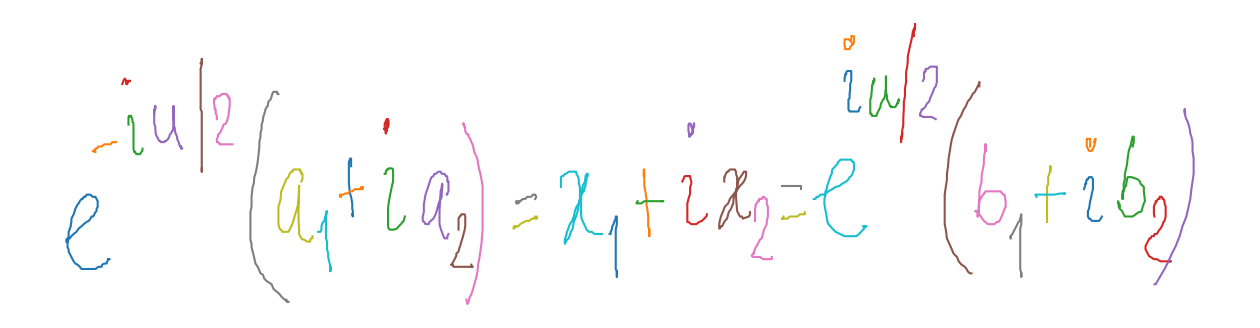

In [ ]:
inkml_path = 'dataset/crohme2019/crohme2019/test/ISICal19_1201_em_758.inkml'
ink = Inkml(inkml_path)
ink.view()

In [ ]:
#display shapes of first 5 traces in one file
traces = ink.getTraces() #list of trace, each trace is a list of points
#traces[0]
[np.array(trace).shape for trace in ink.getTraces()][:5]

[(81, 2), (17, 2), (34, 2), (17, 2), (59, 2)]

> **REMARK**: _Some Inkml may return (x, y, t) coordinates, while most of them return (x, y) coordinates. Make sure to handle this inconsistency in your implementation._

### Build Dataset

For calculating the Connectionist Temporal Classification (CTC) loss, read the [expected output](https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html) of this loss function from PyTorch.

> _Hint: focus on the shapes and the expected variables. (see code example for calculating loss)_
> ```python
> loss = ctc_loss(input_tensor, target_tensor, input_lengths, target_lengths)
> ```

**Base on the observation, how can we build a dataset class from the dataset files?**

> Hints:
>   - *Understand the big picture. (Dataflow)*
>   - *What informations needed to calculate our Loss?*
>   - *What should be returned in the `__getitem__` method?*
>   - *The outputs should be of Tensor type*
   
***References from pytorch [tutorials](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)***

`torch.utils.data.Dataset` is an abstract class representing a dataset. Your custom dataset should inherit `Dataset` and override the following methods:

- `__len__` so that `len(dataset)` returns the size of the dataset.

- `__getitem__` to support the indexing such that `dataset[i]` can be used to get ith sample.


### Feature representation

In this task, we will convert the strokes into feature representations that can be used by the model.

Initially, the `.getTraces()` method returns list of strokes, where each stroke is a list of (x, y) coordinates. Intuitively, we can use those coordinates as features. But if directly using the coordinates as features, the model will have a hard time learning the patterns.

Instead, we can calculate the difference *(∆d)* between consecutive coordinates as features. This way, the model can learn the patterns more easily.

$\Delta_x = x_{i+1} - x_i$ and $\Delta_y = y_{i+1} - y_i$

The feature would then be normalized as

($\frac{\Delta_x}{d}$ , $\frac{\Delta_y} {d}$), where $d = \sqrt{\Delta_x^2 + \Delta_y^2}$

**Pen-up and Pen-down**

In the dataset, each stroke is separated by a pen-up event. We can use this information to separate the strokes.

1. The pen is lifted from the paper (connecting the end of a stroke to the start of a stroke): $pen\_up = 1$
2. The pen is on the paper: $pen\_up = 0$

Then, our feature representation would be:
($\frac{\Delta_x}{d}$ , $\frac{\Delta_y} {d}$, $d$, $pen\_up$)


```
point 1: (x1, y1)
point 2: (x2, y2)
point 3: (x3, y3) <--- end of stroke #1
point 4: (x4, y4) <--- start of stroke #2
...
point n: (xn, yn)
```

The feature representation will be:

```
f1 = ((x2 - x1) / d, (y2 - y1)/d, d, 0)
f2 = ((x3 - x2) / d, (y3 - y2)/d, d, 0)
f3 = ((x4 - x3) / d, (y4 - y3)/d, d, 1) <-- pen up
...
fn-1 = ((xn - xn-1) / d, (yn - yn-1)/d, d, 0)
```

#### **CHECK LIST**

For each data sample, we will do the following steps
- Combine all the strokes into a single stroke (N, 2)
- Compute first order differences of x and y coordinates
- Compute Euclidean distances between consecutive points
- Remove any zero length consecutive points
- Normalize the x and y coordinates by Euclidean distance
- Add feature pen-up/pen-down
> *Features of transformed data: (delta traces, distance, pen_up_down)*

Label
- Define label (list of indices of the words)

Finally, we will convert the data and label to PyTorch tensors.
- Convert data and label to PyTorch tensors

In [ ]:
class InkmlDataset(Dataset):
    def __init__(self, annotation, root_dir, vocab):
        """
        Arguments:
            annotation (string): annotation file txt.
            root_dir (string): directory holds the dataset.
            vocab (set): of vocab.
        """
        self.annotation = annotation
        self.root_dir = root_dir
        self.vocab = vocab

        # load annotations
        self.inks = []
        self.labels = []

        # your code for create self.inks and self.labels from the annotation file

        with open(annotation, 'r', encoding="utf-8") as f:
          for line in f:
            parts = line.strip().split("\t")
            if len(parts) == 2:
              file_name, label = parts

              inkml_obj = Inkml(os.path.join(root_dir, file_name))
              trace = inkml_obj.getTraces()
              self.inks.append(trace)
              self.labels.append(label.strip().split())

    def __len__(self):
        """This code should return the number of samples in the dataset"""
        return len(self.labels)

    def __getitem__(self, idx):
        """This code should return the idx-th sample in the dataset"""

        ink = self.inks[idx]
        label = self.labels[idx]

        # TODO: feature engineering and return the correct data.
         # if you want to check your implementation of feature engineering,
        # write the feature extraction function

        features = []
        for i, stroke in enumerate(ink):
          stroke = np.array(stroke)
          for j in range(1, len(stroke)):
            x1, y1 = stroke[j - 1][0], stroke[j - 1][1]
            x2, y2 = stroke[j][0], stroke[j][1]
            dx = x2 - x1
            dy = y2 - y1
            dist = np.sqrt(dx ** 2 + dy ** 2)
            if dist == 0:
                continue
            features.append([dx / dist, dy / dist, dist, 0])  # pen_down

          if i < len(ink) - 1:
            last_x, last_y = stroke[-1][0], stroke[-1][1]
            next_first = np.array(ink[i + 1])[0]
            x_next, y_next = next_first[0], next_first[1]
            dx = x_next - last_x
            dy = y_next - last_y
            dist = np.sqrt(dx ** 2 + dy ** 2)
            if dist == 0:
                continue
            features.append([dx / dist, dy / dist, dist, 1])  # pen_up

        features = torch.tensor(features, dtype=torch.float32)

        label_ids = self.vocab.encode(label)
        label_tensor = torch.tensor(label_ids, dtype=torch.long)

        input_len = torch.tensor([features.shape[0]], dtype=torch.long)
        label_len = torch.tensor([len(label_ids)], dtype=torch.long)

        pen_down_tensor = features[:, 3].clone().detach().long()
        pen_down_tensor = 1 - pen_down_tensor

        return features, label_tensor, input_len, label_len, pen_down_tensor

In [ ]:
len(traces), traces[0]

(45,
 [[79, 378],
  [79, 378],
  [79, 376],
  [81, 375],
  [85, 375],
  [88, 373],
  [92, 371],
  [97, 369],
  [101, 366],
  [106, 364],
  [110, 362],
  [115, 360],
  [119, 359],
  [122, 357],
  [124, 355],
  [127, 355],
  [129, 353],
  [131, 351],
  [133, 350],
  [133, 348],
  [135, 346],
  [135, 344],
  [135, 343],
  [135, 341],
  [133, 339],
  [131, 337],
  [129, 337],
  [127, 337],
  [126, 337],
  [122, 335],
  [120, 335],
  [119, 335],
  [117, 335],
  [115, 335],
  [113, 337],
  [111, 337],
  [110, 337],
  [108, 339],
  [106, 339],
  [103, 341],
  [101, 343],
  [99, 344],
  [97, 346],
  [95, 348],
  [94, 350],
  [92, 353],
  [90, 355],
  [88, 357],
  [88, 360],
  [87, 362],
  [87, 364],
  [85, 366],
  [85, 367],
  [83, 369],
  [83, 373],
  [83, 375],
  [81, 380],
  [81, 382],
  [81, 383],
  [83, 385],
  [83, 387],
  [85, 389],
  [87, 391],
  [92, 396],
  [95, 398],
  [99, 399],
  [103, 401],
  [106, 403],
  [110, 403],
  [115, 403],
  [120, 403],
  [131, 403],
  [136, 401],
  [142

(3444, 2) (3444,) (3444,)
(3444, 4)
(614, 4)


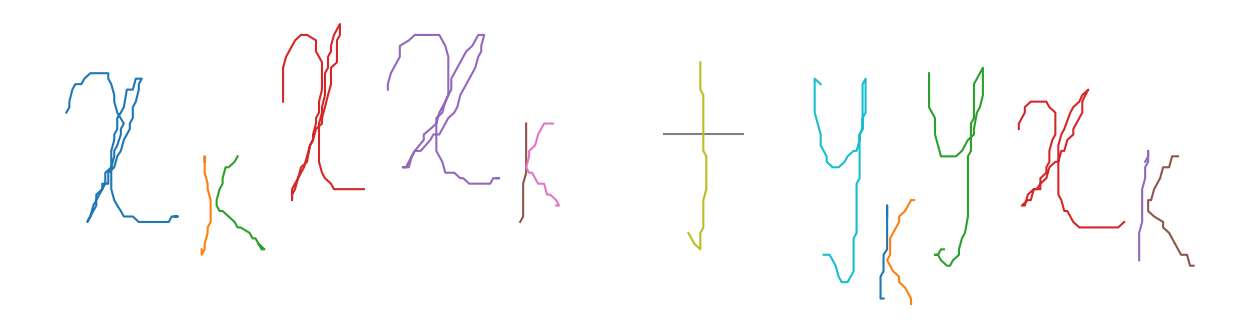

In [ ]:
def feature_extraction(traces):
    feature = np.empty(1)

    # get lengths of each traces
    trace_lengths = [len(trace) for trace in traces]

    # cumulative sum of the lengths
    cum_trace_lengths = np.cumsum(trace_lengths)

    # number of points
    n_points = cum_trace_lengths[-1]

    # create pen-up/down features
    pen_up_down_feature = np.zeros(n_points - 1)

    pen_up_down_feature[cum_trace_lengths[:-1] - 1 ] = 1


    # - Combine all the strokes into a single stroke (N, 2)
    traces = np.concatenate(traces)

    # - Compute first order differences of x and y coordinates
    # deltas = np.diff(traces, axis=0)
    deltas = traces[1:] - traces[:-1] # delta_x, delta_y

    # print(deltas.shape) (3444, 2)
    # shape of deltas?

    # - Compute Euclidean distances between consecutive points
    distances = np.sqrt( np.sum(deltas * deltas, axis=1) )

    print (deltas.shape, distances.shape, pen_up_down_feature.shape)
    # concatenate features
    feature_concatenate = np.concatenate([deltas, distances[:, np.newaxis],
                                          pen_up_down_feature[:,np.newaxis]], axis=1)
    print(feature_concatenate.shape)
    # - Remove any zero-length distances between points

    # find index with zero-length distances
    # print(np.where(feature_concatenate[:, 2]  == 0)[0].shape)

    feature_without_zero_length = feature_concatenate[np.where(feature_concatenate[:, 2]  != 0)]
    print(feature_without_zero_length.shape)

    # feature_without_zero_length = np.delete(feature_concatenate, np.where(feature_concatenate[:, 2]  == 0)[0], axis=0)
    # print(feature_without_zero_length.shape)


    # - Normalize the x and y coordinates by Euclidean distance
    # (delta_x/d, delta_y/d, d, pen_up)
    feature_normalized = feature_without_zero_length.copy()
    # feature_normalized[:, 0] /= feature_without_zero_length[:, 2]
    # feature_normalized[:, 1] /= feature_without_zero_length[:, 2]
    feature_normalized[:, :2] /= feature_without_zero_length[:, 2][:, np.newaxis] # broadcasting (3444, 2) / (3444, 1)
    feature = feature_normalized
    # print(feature_normalized[:20, :])

    return feature


# test code for feature extraction


inkml_path = 'dataset/crohme2019/crohme2019/valid/18_em_0.inkml'
ink = Inkml(inkml_path)
ink.view()

traces = ink.getTraces()
feature = feature_extraction(traces)


import numpy.testing as npt
assert feature.shape == (614, 4)
npt.assert_allclose(feature[:, :3].mean(axis=0), np.array([ 0.17677799,  0.29519369, 11.35540311]))
npt.assert_allclose(feature[:,:3].var(axis=0), np.array([3.75390418e-01, 5.06219812e-01, 4.19017361e+02])
)


## Task 3: Build Lightning Data Module via Dataloader

Revise [this tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders) to see how you can prepare your data for training with DataLoader.

Then refer to this [documentation](https://pytorch.org/docs/stable/data.html#loading-batched-and-non-batched-data) to understand how DataLoader in PyTorch loads Batched or Non-Batched data.

> **TASK:** Write the dataloader with custom collate function to pad the input and target sequence

For a better understanding of the importance of handling variable-length sequences in deep learning models, it is crucial to format and pad the data appropriately to ensure consistency during training. Learn more about this topic [here](https://plainenglish.io/blog/understanding-collate-fn-in-pytorch-f9d1742647d3).

> _**Hint 1**: use `torch.nn.utils.rnn.pad_sequence` to pad the input and target sequences. Read more about this function [here](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html)._

> _**Hint 2**: read Example 3 from this [tutorial](https://www.programiz.com/python-programming/methods/built-in/zip) to unpack data using `zip()`._

In [ ]:
# Bonus 2
def collate_fn(batch):
    """Create batch"""
     # TODO: your custom colate function
    features, labels, input_lens, label_lens, pen_downs = zip(*batch)

    features = pad_sequence(features, batch_first=True, padding_value=0)
    labels = pad_sequence(labels, batch_first=True, padding_value=-100)
    pen_downs = pad_sequence(pen_downs, batch_first=True, padding_value=0)

    input_lens = torch.stack(input_lens)
    label_lens = torch.stack(label_lens)

    return features, labels, input_lens, label_lens, pen_downs

In [ ]:
dataset = InkmlDataset(
    annotation="/content/dataset/crohme2019_train.txt",
    root_dir="/content/dataset/crohme2019",
    vocab=vocab)  # TODO: initialize a dataset

# Bonus 2
features, labels, input_lens, label_lens, pen_downs = collate_fn([dataset[0], dataset[1]])

import numpy.testing as npt

assert type(input_lens) == torch.Tensor
assert type(label_lens) == torch.Tensor

> **TASK:** implement InkmlDataset_PL Lightning Datamodule

In [ ]:
class InkmlDataset_PL(pl.LightningDataModule):
    """
    PyTorch Lightning data module for handling the INKML dataset.
    """

    def __init__(
        self,
        batch_size: int = 10,
        workers: int = 5,
        train_data: str = "",
        val_data: str = "",
        test_data: str = "",
        root_dir: str = "dataset",
        vocab_file: str = ""
    ):
        super().__init__()
        self.batch_size = batch_size
        self.workers = workers
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.root_dir = root_dir
        self.vocab_file = vocab_file

        self.vocab = Vocab(self.vocab_file)

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
          self.train_dataset = InkmlDataset(self.train_data, root_dir=self.root_dir, vocab=self.vocab)
          self.val_dataset = InkmlDataset(self.val_data, root_dir=self.root_dir, vocab=self.vocab)
        if stage == "test" or stage is None:
          self.test_dataset = InkmlDataset(self.test_data, root_dir=self.root_dir, vocab=self.vocab)

    def custom_collate_fn(self, data):
        # TODO: provide your custom collate function here.
        # Bonus 2
        traces, labels, len_trace, len_label, pen_downs = zip(*data)

        padded_traces = pad_sequence(traces, batch_first=True, padding_value=0.0)
        padded_labels = pad_sequence(labels, batch_first=True, padding_value=-100)
        padded_pen_downs = pad_sequence(pen_downs, batch_first=True, padding_value=0)

        len_traces = torch.stack(len_trace)
        len_labels = torch.stack(len_label)
        return padded_traces, padded_labels, len_traces, len_labels, padded_pen_downs
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.workers,
            collate_fn=self.custom_collate_fn,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.workers,
            collate_fn=self.custom_collate_fn,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.workers,
            collate_fn=self.custom_collate_fn,
        )

## Task 4: Build Model

In this task, we will build a model that will be used to train the dataset.
The model will be a simple RNN with a single layer of Bidirectional LSTM cells. The model will take the input from the dataset and output the predicted sequence of symbols and relations and will use CTC loss to train the model.

The model will be built using PyTorch and will use the following architecture


> _We highly recommend you to read through this [tutorial on Creating a model using Pytorch](https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html) and understand the basic building blocks of a model in PyTorch._

> _**ATTENTION** Below is the architecture for the model. You must **STRICTLY** follow the architecture and the parameters mentioned below._
> | Layer Type         | Configuration                              |
> |--------------------|--------------------------------------------|
> | Input              | Sequence of vectors with `input_size=4`    |
> | LSTM Layer         | `hidden_size=256`, `num_layers=2`          |
> |                    | `batch_first=True`                         |
> |                    | `bidirectional=True`                       |
> | LSTM Output        | Output shape: `(batch_size, seq_len, hidden_size*2)`|
> | Fully Connected    | `Linear(hidden_size*2, num_classes)`|
> | Activation         | `LogSoftmax(dim=...)`|
> | Output             | `(batch_size, seq_len, num_classes)`|


In [ ]:
class LSTM_TemporalClassification(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM_TemporalClassification, self).__init__()
        # TODO: declare layers here
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, x):
        # TODO: write calculation process here
        # x shape: (batch_size, seq_len, input_size)
        x, _ = self.lstm(x)  # x: (batch_size, seq_len, hidden_size*2)
        x = self.fc(x)       # x: (batch_size, seq_len, num_classes)
        x = self.log_softmax(x)  # x: (batch_size, seq_len, num_classes)
        return x

In [ ]:
# Test your implementation
model = LSTM_TemporalClassification(4, 256, 2, 109)
assert model.forward(torch.rand((10, 100, 4))).shape == (10, 100, 109)

## Task 5: Understand CTC Loss

In this task, we will understand how to use CTC loss to train the model. The CTC loss is used to train the model to predict the sequence of symbols and relations from the input sequence of features.

> _For deeper understanding of CTC loss, read this [blog](https://distill.pub/2017/ctc/)_

Check out this [Pytorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html) to learn more about its implementation.

> _Hint: read the expected input and output of the CTC loss function. The input should be of shape `(T, N, C)` where T is the length of the input sequence, N is the batch size, and C is the number of classes. The target should be of shape `(N, S)` where S is the length of the target sequence._

After understanding how CTC Loss works, we can proceed to implement it in our model.

## Task 6: Build Lightning Module

In this task, we will build a Lightning module that will be used to train the model. The Lightning module will mostly be used to define the training and validation steps, as well as the optimizer and learning rate scheduler.

> _More on building Lightning module can be found [here](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html). You should read about core methods to know what to implement in your module._

In [ ]:
class MathOnlineModel(pl.LightningModule):
    def __init__(
        self,
        lr=0.001,
        input_size=4,
        output_size=109,
        hidden_size=256,
        num_layers=2,
        decoder=None,
        # Bonus 2
        vocab = None,
    ):
        super().__init__()
        self.model = LSTM_TemporalClassification(
            input_size, hidden_size, num_layers, output_size
        )
        self.criterion = nn.CTCLoss(blank=0, zero_infinity=True)
        # TODO: define CTC Loss Function here.
        self.lr = lr
        self.decoder = decoder
        # Bonus 2
        self._validation_outputs = []
        self.vocab = vocab
        self.relation_indices = [self.vocab.char2idx[r] for r in RELATIONS]

    # Bonus 2
    def compute_constraint_loss(self, out, pen_down):
        out_prob = torch.softmax(out, dim=2)
        p_rel = out_prob[:, :, self.relation_indices].sum(dim=2)
        mask = pen_down.T.float()
        eps = 1e-7
        rel_penalty = (p_rel * mask).sum(dim=0)
        rel_penalty = rel_penalty.clamp(min=0.0, max=1.0 - eps)
        constraint_loss = -torch.log(1 - rel_penalty + eps).mean()
        if torch.isnan(constraint_loss) or torch.isinf(constraint_loss):
            constraint_loss = torch.tensor(0.0, device=constraint_loss.device)
        return constraint_loss

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y, x_lens, y_lens, pen_down = batch

        # TODO: your code to calculate loss
        # Bonus 2
        out = self.model(x)
        out = out.permute(1, 0, 2)  # [T, B, C]
        ctc_loss = self.criterion(out, y, x_lens, y_lens)
        constraint_loss = self.compute_constraint_loss(out, pen_down)
        lambda_constr = 0.01  # if loss is large, decrease lambda_constr
        loss = ctc_loss + lambda_constr * constraint_loss

        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log("constraint_loss", constraint_loss, prog_bar=True, on_step=True, on_epoch=True)

        lr = self.trainer.optimizers[0].param_groups[0]['lr']
        self.log("lr-Adam", lr, prog_bar=True, on_step=True, on_epoch=False)

        return loss

    def on_validation_epoch_start(self):
        self._validation_outputs = []

    def validation_step(self, batch, batch_idx):
        x, y, x_lens, y_lens, pen_down = batch
        out = self.model(x)
        out = out.permute(1, 0, 2)
        loss = self.criterion(out, y, x_lens, y_lens)
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)

        batch_edit_dist = 0
        batch_tgt_len = 0
        batch_edit_dist_sym = 0
        batch_tgt_len_sym = 0
        batch_edit_dist_rel = 0
        batch_tgt_len_rel = 0

        if self.decoder is not None:
            with torch.no_grad():
                decoded_preds = self.decoder(out.permute(1, 0, 2))
            decoded_targets = []
            for label, length in zip(y, y_lens):
                decoded_targets.append([self.vocab.idx2char[idx.item()] for idx in label[:length]])
            for pred, tgt in zip(decoded_preds, decoded_targets):
                pred_tokens = pred.split() if isinstance(pred, str) else pred

                # Wer
                edit_dist = edit_distance(pred_tokens, tgt)
                batch_edit_dist += edit_dist
                batch_tgt_len += len(tgt)

                # Wer_sym
                tgt_sym = extract_symbols(tgt)
                pred_sym = extract_symbols(pred_tokens)
                batch_edit_dist_sym += edit_distance(pred_sym, tgt_sym)
                batch_tgt_len_sym += len(tgt_sym)

                # Wer_rel
                tgt_rel = extract_relations(tgt)
                pred_rel = extract_relations(pred_tokens)
                batch_edit_dist_rel += edit_distance(pred_rel, tgt_rel)
                batch_tgt_len_rel += len(tgt_rel)
        self._validation_outputs.append({
            "val_loss": loss.detach().cpu(),
            "wer_dist": batch_edit_dist,
            "wer_len": batch_tgt_len,
            "wer_dist_sym": batch_edit_dist_sym,
            "wer_len_sym": batch_tgt_len_sym,
            "wer_dist_rel": batch_edit_dist_rel,
            "wer_len_rel": batch_tgt_len_rel,
        })

    def on_validation_epoch_end(self):
        outputs = self._validation_outputs
        sum_wer_dist = sum(x['wer_dist'] for x in outputs)
        sum_wer_len = sum(x['wer_len'] for x in outputs)
        sum_wer_dist_sym = sum(x['wer_dist_sym'] for x in outputs)
        sum_wer_len_sym = sum(x['wer_len_sym'] for x in outputs)
        sum_wer_dist_rel = sum(x['wer_dist_rel'] for x in outputs)
        sum_wer_len_rel = sum(x['wer_len_rel'] for x in outputs)

        wer = sum_wer_dist / sum_wer_len if sum_wer_len > 0 else 0.0
        wer_sym = sum_wer_dist_sym / sum_wer_len_sym if sum_wer_len_sym > 0 else 0.0
        wer_rel = sum_wer_dist_rel / sum_wer_len_rel if sum_wer_len_rel > 0 else 0.0

        self.log('val_wer', wer, prog_bar=True, on_epoch=True)
        self.log('wer_symb', wer_sym, prog_bar=True, on_epoch=True)
        self.log('wer_rel', wer_rel, prog_bar=True, on_epoch=True)

        if outputs:
            val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
            self.log("val_loss", val_loss, prog_bar=True, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y, x_lens, y_lens, pen_downs = batch

        # TODO: your code to calculate loss
        out = self.model(x)
        out = out.permute(1, 0, 2)
        loss = self.criterion(out, y, x_lens, y_lens)

        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        return [optimizer], [scheduler]
        # return torch.optim.Adam(self.model.parameters(), lr=self.lr)

## Task 7: Train the Model with PyTorch Lightning

Read more about Training with PyTorch Lightning [here](https://lightning.ai/docs/pytorch/stable/common/trainer.html) and understand how to use the Trainer class to train the model.

From the documentation:

> The Lightning Trainer does much more than just “training”. Under the hood, it handles all loop details for you, some examples include:
> - Automatically enabling/disabling grads
> - Running the training, validation and test dataloaders
> - Calling the Callbacks at the appropriate times
> - Putting batches and computations on the correct devices

> **IMPORTANT**: You must config your WandB logger to log the training and validation metrics. Without this, your work will not be graded.

In [ ]:
student_id = "10422069"  # TODO: replace with your student ID
api_key = os.environ.get("WANDB_API_KEY", "778839b0f7e842609153a768790b705362dadf02")  # configure your wandb key here

if api_key == "":
    raise ValueError("Please set your wandb key in the code or in the environment variable WANDB_API_KEY")
else:
    print("WandB API key is set. Proceeding with login...")

wandb.login(key=api_key)

WandB API key is set. Proceeding with login...


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 10422069 (10422069-vietnamese-german-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# Download checkpoint model from wandb.ai
api = wandb.Api()
artifact = api.artifact('cuong-nt-vgu-ai-2025/math_online_2025/model-pixkwijx:v4', type='model') # The best model
artifact_dir = artifact.download()

wandb:   1 of 1 files downloaded.  


In [ ]:
wandb_logger = WandbLogger(
    entity="cuong-nt-vgu-ai-2025",  # DO NOT CHANGE THIS
    project="math_online_2025", # DO NOT CHANGE THIS
    name=f"{student_id}_run_1",
    config={
        "student_id": student_id,  # DO NOT CHANGE THIS
        "model": "LSTM_TemporalClassification",
        # your hyperparameters
        "lr": 0.001,
        "batch_size": 36,
        "max_epochs": 20,
    },
    log_model=True,
    save_dir="wandb_logs",
)

dm = InkmlDataset_PL(root_dir='/content/dataset/crohme2019',
                       train_data='/content/dataset/crohme2019_train.txt',
                       val_data='/content/dataset/crohme2019_valid.txt',
                       test_data='/content/dataset/crohme2019_test.txt',
                       vocab_file='vocab.json',
                       batch_size=36,
                      workers=4
                     )

# model = MathOnlineModel(vocab=dm.vocab)
ckpt_path = os.path.join(artifact_dir, "model.ckpt")
model = MathOnlineModel.load_from_checkpoint(
      ckpt_path,
      vocab=dm.vocab,
      decoder=GreedyCTCDecoder(vocab)
    )

trainer = Trainer(
    callbacks = [
        LearningRateMonitor(logging_interval='step'),
        ModelCheckpoint(filename='{epoch}-{val_wer:.4f}', save_top_k=5, monitor='val_wer', mode='min'),
    ],
    logger = wandb_logger,
    check_val_every_n_epoch=1,
    fast_dev_run=False,  # enable for testing model
    default_root_dir='checkpoint',
    deterministic=False,
    max_epochs=20,
    log_every_n_steps=50,
    devices = "auto",
)

trainer.fit(model, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | model     | LSTM_TemporalClassification | 2.2 M  | train
1 | criterion | CTCLoss                     | 0      | train
2 | decoder   | GreedyCTCDecoder            | 0      | train
------------------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.678     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


**Requirements:**
- Validation loss (val_loss < 0.7)

**Tips on training:**
- Debug with **fast_dev_run**:
Before run the training process, it is better to make a quick check of training and validation loop. Set fast_dev_run=True, then run the trainer and check if there is any bug exist.
- Training initially with **small batch size**:
In practice, training with CTC loss converges slowly for large batch size. To accelerate convergence, training with small batch size first, save model, then, train with large batch size.
- Train more epochs by setting:

```python
trainer = Trainer(
    ...
    max_epochs=20,
    ...
)
```

## Task 8: Test your model

Run the test set and check the accuracy of your model. The test set is used to evaluate the performance of the model on unseen data.

In [ ]:
trainer = Trainer(
    devices=1,
)

dm = InkmlDataset_PL(root_dir='/content/dataset/crohme2019',
                       train_data='/content/dataset/crohme2019_train.txt',
                       val_data='/content/dataset/crohme2019_valid.txt',
                       test_data='/content/dataset/crohme2019_test.txt',
                       vocab_file='vocab.json',
                       batch_size=36,
                      workers=4
                     )

# Load the model from a checkpoint
ckpt_path = os.path.join(artifact_dir, "model.ckpt")
model = MathOnlineModel.load_from_checkpoint(
      ckpt_path,
      vocab=dm.vocab,
    )

# Initialize the data module
dm = InkmlDataset_PL(
    root_dir="/content/dataset/crohme2019",
    train_data='/content/dataset/crohme2019_train.txt',
    val_data='/content/dataset/crohme2019_valid.txt',
    test_data='/content/dataset/crohme2019_test.txt',
    vocab_file="vocab.json",
    batch_size=32,
    workers=4,
)

# Test the model
trainer.test(model, datamodule=dm)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6137259602546692     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6137259602546692}]

## Task 9: Inference

The output of networks need to process by a decoding step.

- Greedy decode: Your task is to implement greedy decoding method. Which converts the output into a string of symbols and relations (same form with labels). Greedy decoder produce the best path by removing consecutive repeated symbols/relations and then remove \<blank\>

> **TASK**: Implement the greedy decoder for the model output.

Based on GreedyCTCDecoder class from this [link](https://pytorch.org/audio/main/tutorials/asr_inference_with_ctc_decoder_tutorial.html#greedy-decoder), write decoding for an output. Your implementation should handle the output of the model and convert it into a string of symbols and relations, ensuring to remove consecutive repeated symbols/relations and the blank token.

In [ ]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, vocab):
        super().__init__()
        self.vocab = vocab
        self.blank = vocab.char2idx["<blank>"]

    def forward(self, emission: torch.Tensor) -> list:
        """Given a sequence emission over labels, get the best path
        Args:
          emission (Tensor): Logit tensors. Shape `[seq_len, num_label]`.

        Returns:
          list: The resulting transcript
        """
        # TODO: implement the decoder

        if emission.dim() == 2:
            emission = emission.unsqueeze(0)

        output_seq_list = []
        for em in emission:
            pred_indices = em.argmax(dim=-1).tolist()
            decoded = []
            prev_idx = None
            for idx in pred_indices:
                if idx != self.blank and idx != prev_idx:
                    decoded.append(self.vocab.idx2char[idx])
                prev_idx = idx
            output_seq_list.append(" ".join(decoded))

        return output_seq_list

Then you can test the output of your model here

In [ ]:
annotation = '/content/dataset/crohme2019_test.txt'
root_dir = '/content/dataset/crohme2019'
vocab = Vocab('vocab.json')

ckpt_path = os.path.join(artifact_dir, "model.ckpt")
model = MathOnlineModel.load_from_checkpoint(
      ckpt_path,
      vocab=dm.vocab
    )
model.eval()

model = model.to('cpu')

dataset = InkmlDataset(annotation, root_dir, vocab)
feature, label, input_len, label_len, pen_downs = dataset[0]

vocab = Vocab('vocab.json')
greedy_decoder = GreedyCTCDecoder(vocab)

decoded_output = greedy_decoder.forward(model(feature.unsqueeze(0)))

print(decoded_output)

# possible output if your training work well
# decoded -> ['\\phi', 'Right', '(', 'Right', '0', 'Right', '(', 'Right', 'n', 'Right', ')', 'Right', ')']


['4 Sub n Right - Right 4 Right 1 NoRel 6 NoRel - Right 2 Right n Right - Right 1 - Right 1 NoRel ( NoRel = Right 2 Right n Right - Right 3']


## Task 10: Implement calculation metric for training

In [ ]:
def edit_distance(pred_seq: list, label_seq: list):
    # TODO: implement Token Edit distance
    m, n = len(pred_seq), len(label_seq)
    dp = [[0]*(n+1) for _ in range(m+1)]
    for i in range(m+1):
        dp[i][0] = i
    for j in range(n+1):
        dp[0][j] = j

    for i in range(1, m+1):
        for j in range(1, n+1):
            if pred_seq[i-1] == label_seq[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = 1 + min(
                    dp[i-1][j],    # deletion
                    dp[i][j-1],    # insertion
                    dp[i-1][j-1],  # substitution
                )
    distance = dp[m][n]
    return distance


# Test your implementation
assert (
    edit_distance(
        [
            "\\phi",
            "Right",
            "(",
            "Right",
            "0",
            "Right",
            "(",
            "Right",
            "n",
            "Right",
            ")",
            "Right",
            ")",
        ],
        [
            "\\phi",
            "Right",
            "(",
            "Right",
            "\\phi",
            "Right",
            "(",
            "Right",
            "n",
            "Right",
            ")",
            "Right",
            ")",
        ],
    )
    == 1
)

> **TASK**: Implement word error rate metric (wer) for training,  validation and testing in your model.
>
> $wer = \frac{total\ edit\ distance (predict\ sequence,\ target\ sequence)}{total\ target\ sequence\ length}$


**Steps to process:**

- Decode the predicted sequences to obtain the text output.
- Calculate the total edit distance between the predicted and target sequences.
- Compute the word error rate using the formula provided.
- Log the WER metric during training and validation.

**Continue to train the model**

- Load the latest trained model:

```
model = MathOnlineModel.load_from_checkpoint('path/to/your/checkpoint.ckpt')
```
- Change config of ModelCheckPoint to monitor the new metric (val_wer) instead.

```
        ModelCheckpoint(filename='{epoch}-{val_loss:.4f}', save_top_k=5, monitor='val_loss', mode='min')
        
      --> ModelCheckpoint(filename='{epoch}-{val_wer:.4f}', save_top_k=5, monitor='val_wer', mode='min'),

```


Ground truth tokens: F Sup 1 NoRel 0
Predicted tokens (remove <blank>): F Sup 1 NoRel 0


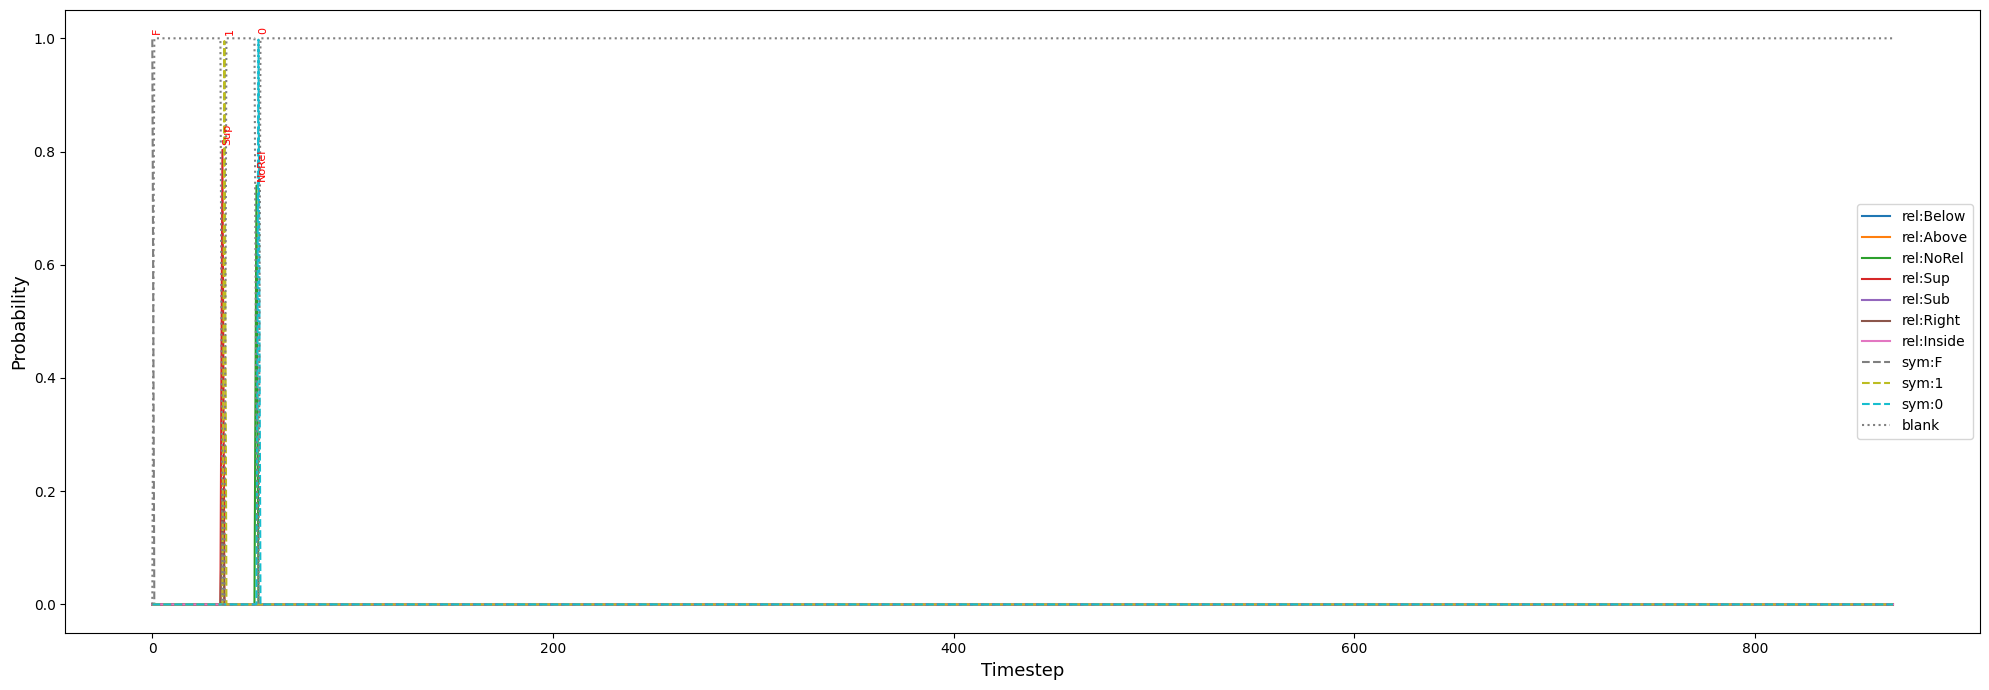

In [ ]:
# Bonus 3

datamodule = InkmlDataset_PL(
    root_dir="/content/dataset/crohme2019",
    train_data='/content/dataset/crohme2019_train.txt',
    val_data='/content/dataset/crohme2019_valid.txt',
    test_data='/content/dataset/crohme2019_test.txt',
    vocab_file="vocab.json",
    batch_size=32,
    workers=4,
)
datamodule.setup()
val_loader = datamodule.val_dataloader()

batch = next(iter(val_loader))
x, y, x_lens, y_lens, pen_down = batch
min_len_idx = x_lens.argmin().item()

model.eval()
with torch.no_grad():
    out = model(x)
    # Đảm bảo shape là [batch, seq_len, num_class]
    if out.shape[0] == x.shape[1]:
        out = out.permute(1, 0, 2)
    logits = out[min_len_idx]  # chọn sample ngắn nhất

probs = F.softmax(logits, dim=-1).cpu().numpy()  # [seq_len, num_class]

pred_indices = probs.argmax(axis=-1)
pred_tokens = [datamodule.vocab.idx2char[idx] for idx in pred_indices]
prediction = [tok for tok in pred_tokens if tok != "<blank>"]

gt_indices = y[min_len_idx][:y_lens[min_len_idx]].cpu().numpy()
gt_tokens = [datamodule.vocab.idx2char[idx] for idx in gt_indices]
print("Ground truth tokens:", " ".join(gt_tokens))
print("Predicted tokens (remove <blank>):", " ".join(prediction))

RELATIONS = {"Right", "Above", "Below", "Sup", "Sub", "Inside", "NoRel"}
relation_names = [r for r in RELATIONS if r in datamodule.vocab.char2idx]
relation_indices = [datamodule.vocab.char2idx[r] for r in relation_names]

# Vẽ symbol thực tế xuất hiện trong ground truth
symbols_in_gt = [s for s in gt_tokens if s not in RELATIONS and s != "<blank>"]
symbols_in_gt = list(dict.fromkeys(symbols_in_gt))  # remove duplicates
symbol_indices = [datamodule.vocab.char2idx[s] for s in symbols_in_gt if s in datamodule.vocab.char2idx]

timesteps = np.arange(probs.shape[0])
plt.figure(figsize=(20, 7))
for i, rel_idx in enumerate(relation_indices):
    plt.plot(timesteps, probs[:, rel_idx], label=f"rel:{relation_names[i]}")
for i, sym_idx in enumerate(symbol_indices):
    plt.plot(timesteps, probs[:, sym_idx], linestyle="--", label=f"sym:{symbols_in_gt[i]}")

# Vẽ xác suất <blank>
blank_idx = datamodule.vocab.char2idx["<blank>"]
plt.plot(timesteps, probs[:, blank_idx], linestyle=":", color="gray", label="blank")

# Annotate token model predict lên từng timestep (không phải <blank>)
for t, tok in enumerate(pred_tokens):
    if tok != "<blank>":
        plt.text(t, 1.01 * probs[t].max(), tok, rotation=90, va='bottom', color='red', fontsize=8)

# plt.title("Softmax probability by timestep (relations, ground truth symbols, blank & predicted tokens)", fontsize=15)
plt.xlabel("Timestep", fontsize=13)
plt.ylabel("Probability", fontsize=13)
plt.legend()
plt.tight_layout()
# plt.xlim(0, min(200, len(timesteps)))  # zoom vào đoạn đầu cho dễ nhìn
plt.show()

## **BONUS TASKS**

The following tasks are optional and can be done for extra credit to the final exam.

### **Bonus 1**: Add metric to evaluate accuracy of symbols and relations seperately *(+0.5pt)*

**Add the metrics: wer for symbols and wer for relations**
```
self.log('wer_sym',...)
self.log('wer_rel',...)
```

### **Bonus 2**: Modify loss function to constraint the output of relations at the time step of pen-up *(+1pt)*
Modify loss function to constrain the output of relations at the timestep of pen-up.

The idea: Provide a masked sequence such that the position of pen-up is masked, the additional loss would penaltize all the relations output to the timestep that has been masked.


**Loss function to constraint relation output**

```
pen_down: a masked sequence, where len(pen_down) = len(input_sequence)
        and pen_down[t] == 1 (pen down), pen_down[t] == 0 (pen up)
p_rel: total probability of relation outputs for every time step t, len(p_rel) = len(input_sequence), p_rel[t] = sum(p[t][rel] for rel in ['Sub', 'Sup', 'Above', ...])

The loss is defined as:

    L_{constraint} = -log(1 - sum(p_rel * pen_down))
    
Explanation:

    Minimize L_{constraint} (value range of (-inf, 0)) would make maximize of (1 - sum(p_rel * pen_down)), or making sum(p_rel * mask) -> 0, then it will penalize the relation output on pen_down timesteps.
```

**Apply constraint loss function with ctc loss**

```
    L = loss_{ctc} + \lambda * L_{constraint}
    
where \lambda is a weighted parameter to control balance between the two losses.
   
```


You can also find it in a published paper here, section 3.4:
https://arxiv.org/pdf/2105.10156

### **Bonus 3**: Visualize model prediction by timesteps and probability of softmax outputs *(+0.5pt)*

![alt text](https://github.com/fuisl/crohme-ctc/blob/6722b97ec2000afcd16068220f0b1b83b3134ff8/assets/graph_with_prob.png?raw=true)

### **Bonus 4**: Use CUDA CTC Decoder to optimize decoding process in model *(+0.5pt)*

Follow the instructions via this [link](https://pytorch.org/audio/main/tutorials/asr_inference_with_ctc_decoder_tutorial.html#cuda-ctc-decoder) to implement CUDA CTC decoder in your model.